<a href="https://colab.research.google.com/github/MarcosRigal/CNC/blob/main/P4/P4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 4: Clasificación Semi-Supervisada

**Objetivo**: El objetivo de esta práctica es introducir los conceptos de clasificación semi-supervisada.

La práctica consiste en dos tareas:

## TAREA 1: Implementación de un método
- Seleccione un algoritmo de los indicados en la teoría que implemente aprendizaje semi-supervisado de cualquiera de los paradigmas estudiados.
- Implemente el algoritmo.
- Seleccione al menos un dataset semi-supervisado y evalúe el algoritmo implementado.

## TAREA 2: Comparación de métodos
1. Seleccione al menos dos algoritmos de los disponibles en las bibliotecas indicadas.
2. Seleccione al menos tres problemas semi-supervisados de los repositorios indicados.
3. Aplique los algoritmos seleccionados a los datasets.
4. Compare los resultados y explique las conclusiones obtenidas.

En este notebook se incluye un ejemplo con dos tareas:
1. **Tarea 1**: Implementación y uso de un método de Self-Training.
2. **Tarea 2**: Comparación de Label Spreading y Self-Training sobre datasets generados sintéticamente.


## TAREA 1: Implementación de un método de Self-Training

En esta celda se muestra la implementación de un algoritmo de *Self-Training* desde cero y su posterior evaluación en un dataset sintético. Se entrena un modelo con un pequeño subconjunto etiquetado y se itera sobre instancias no etiquetadas, pseudo-etiquetándolas de forma progresiva si el modelo está suficientemente seguro (superando un determinado umbral de confianza).

In [9]:
import numpy as np
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

def self_training(X_labeled, y_labeled, X_unlabeled, base_classifier,
                  confidence_threshold=0.9, max_iter=10):
    """
    Self-Training method.

    Parameters
    ----------
    X_labeled : array-like, shape (n_labeled_samples, n_features)
        Labeled dataset.
    y_labeled : array-like, shape (n_labeled_samples,)
        Corresponding labels for X_labeled.
    X_unlabeled : array-like, shape (n_unlabeled_samples, n_features)
        Unlabeled dataset.
    base_classifier : scikit-learn estimator
        Base classifier that must support at least the `predict_proba` method.
        (If it does not support `predict_proba`, confidence is assumed to be 1 for all instances).
    confidence_threshold : float, optional (default=0.9)
        Minimum probability threshold to accept pseudo-labeled instances.
    max_iter : int, optional (default=10)
        Maximum number of self-training iterations.

    Returns
    -------
    trained_classifier : scikit-learn estimator
        The trained classifier at the end of the process (or after exhausting
        the unlabeled instances that meet the confidence threshold).
    """

    # Copies to avoid modifying the original data
    X_l = X_labeled.copy()
    y_l = y_labeled.copy()
    X_u = X_unlabeled.copy()

    for i in range(1, max_iter + 1):
        # Create/Clone the classifier to train it from scratch in each iteration
        current_clf = clone(base_classifier)
        current_clf.fit(X_l, y_l)

        # If the classifier has predict_proba, use it to calculate confidence
        if hasattr(current_clf, "predict_proba"):
            probs = current_clf.predict_proba(X_u)
            pred_labels = np.argmax(probs, axis=1)
            max_probs = np.max(probs, axis=1)
        else:
            # If it does not have predict_proba, use predict and assume confidence=1
            pred_labels = current_clf.predict(X_u)
            max_probs = np.ones(len(X_u))

        # Select instances with confidence >= confidence_threshold
        high_conf_idx = np.where(max_probs >= confidence_threshold)[0]

        if len(high_conf_idx) == 0:
            print(f"Iteration {i}: No instances found with confidence >= {confidence_threshold}. Ending.")
            break

        # Add to the labeled dataset
        X_l = np.vstack([X_l, X_u[high_conf_idx]])
        y_l = np.hstack([y_l, pred_labels[high_conf_idx]])

        # Remove from the unlabeled dataset
        X_u = np.delete(X_u, high_conf_idx, axis=0)

        print(f"Iteration {i}: Added {len(high_conf_idx)} high-confidence instances.")

        # If no more unlabeled examples remain, end
        if len(X_u) == 0:
            print(f"Iteration {i}: No more unlabeled instances remaining. Ending.")
            break

    # Train a final classifier with all accumulated labeled data
    final_clf = clone(base_classifier)
    final_clf.fit(X_l, y_l)

    return final_clf

# Example usage with synthetic data
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    # Generate synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=10,
                               n_informative=3, n_classes=2,
                               random_state=42)

    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42)

    # Take only 20% of y_train as labeled
    labeled_percentage = 0.2
    num_labeled = int(len(y_train) * labeled_percentage)
    X_labeled = X_train[:num_labeled]
    y_labeled = y_train[:num_labeled]

    # The rest is considered unlabeled
    X_unlabeled = X_train[num_labeled:]

    # Train using Self-Training with a RandomForest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    self_trained_model = self_training(
        X_labeled,
        y_labeled,
        X_unlabeled,
        rf,
        confidence_threshold=0.9,
        max_iter=10
    )

    # Evaluate on the test set
    y_pred = self_trained_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Test accuracy after Self-Training:", accuracy)


Iteration 1: Added 357 high-confidence instances.
Iteration 2: Added 46 high-confidence instances.
Iteration 3: Added 21 high-confidence instances.
Iteration 4: Added 12 high-confidence instances.
Iteration 5: Added 9 high-confidence instances.
Iteration 6: Added 5 high-confidence instances.
Iteration 7: Added 10 high-confidence instances.
Iteration 8: Added 7 high-confidence instances.
Iteration 9: Added 6 high-confidence instances.
Iteration 10: Added 9 high-confidence instances.
Test accuracy after Self-Training: 0.8933333333333333


## TAREA 2: Comparación de Label Spreading y Self-Training

En la siguiente celda se ilustra cómo comparar dos métodos de clasificación semi-supervisada (Label Spreading y Self-Training) en al menos dos datasets sintéticos. En una entrega final, pueden agregarse más datasets o reemplazar estos por otros de repositorios reconocidos, tal como lo solicita la consigna.


Evaluando Iris con Label Spreading:

Resultados en dataset: Iris
Accuracy: 0.9545, F1-score: 0.9441, Precision: 0.9444, Recall: 0.9524
Matriz de Confusión:
[[10  0  0]
 [ 0  5  0]
 [ 0  1  6]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91         5
           2       1.00      0.86      0.92         7

    accuracy                           0.95        22
   macro avg       0.94      0.95      0.94        22
weighted avg       0.96      0.95      0.95        22



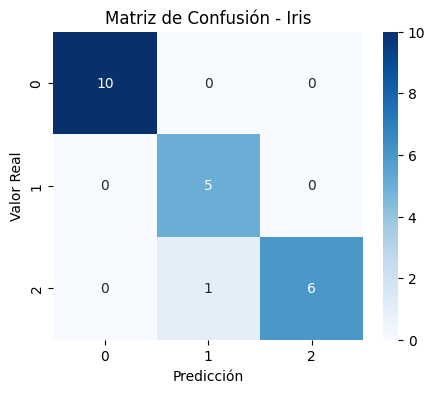


Evaluando Iris con Self-Training:

Resultados en dataset: Iris
Accuracy: 1.0000, F1-score: 1.0000, Precision: 1.0000, Recall: 1.0000
Matriz de Confusión:
[[10  0  0]
 [ 0  5  0]
 [ 0  0  7]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



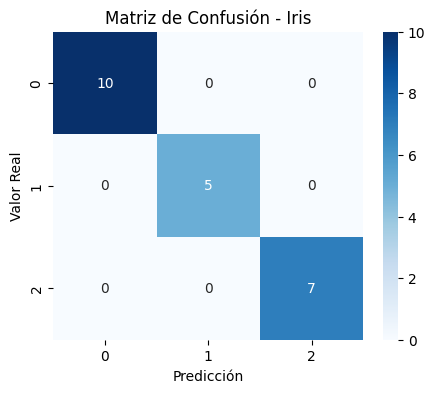


Evaluando Wine con Label Spreading:

Resultados en dataset: Wine
Accuracy: 0.7083, F1-score: 0.7260, Precision: 0.7407, Recall: 0.7163
Matriz de Confusión:
[[6 0 1]
 [0 6 3]
 [0 3 5]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.67      0.67      0.67         9
           2       0.56      0.62      0.59         8

    accuracy                           0.71        24
   macro avg       0.74      0.72      0.73        24
weighted avg       0.73      0.71      0.72        24



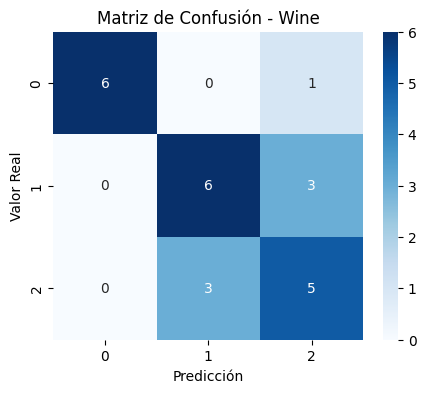


Evaluando Wine con Self-Training:

Resultados en dataset: Wine
Accuracy: 0.5417, F1-score: 0.5517, Precision: 0.6667, Recall: 0.5317
Matriz de Confusión:
[[3 4 0]
 [0 6 3]
 [0 4 4]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.43      0.67      0.52         9
           2       0.57      0.50      0.53         8

    accuracy                           0.54        24
   macro avg       0.67      0.53      0.55        24
weighted avg       0.64      0.54      0.55        24



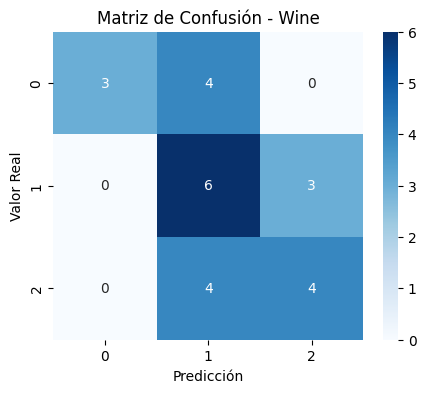


Evaluando Breast Cancer con Label Spreading:

Resultados en dataset: Breast Cancer
Accuracy: 0.9432, F1-score: 0.9373, Precision: 0.9408, Recall: 0.9341
Matriz de Confusión:
[[28  3]
 [ 2 55]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        31
           1       0.95      0.96      0.96        57

    accuracy                           0.94        88
   macro avg       0.94      0.93      0.94        88
weighted avg       0.94      0.94      0.94        88



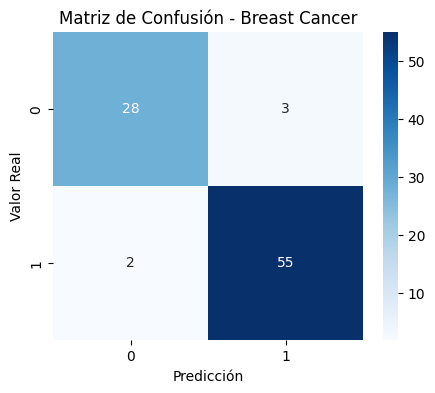


Evaluando Breast Cancer con Self-Training:

Resultados en dataset: Breast Cancer
Accuracy: 0.6705, F1-score: 0.6704, Precision: 0.7420, Recall: 0.7383
Matriz de Confusión:
[[30  1]
 [28 29]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.52      0.97      0.67        31
           1       0.97      0.51      0.67        57

    accuracy                           0.67        88
   macro avg       0.74      0.74      0.67        88
weighted avg       0.81      0.67      0.67        88



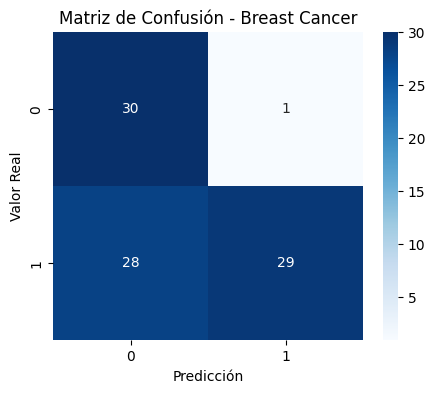

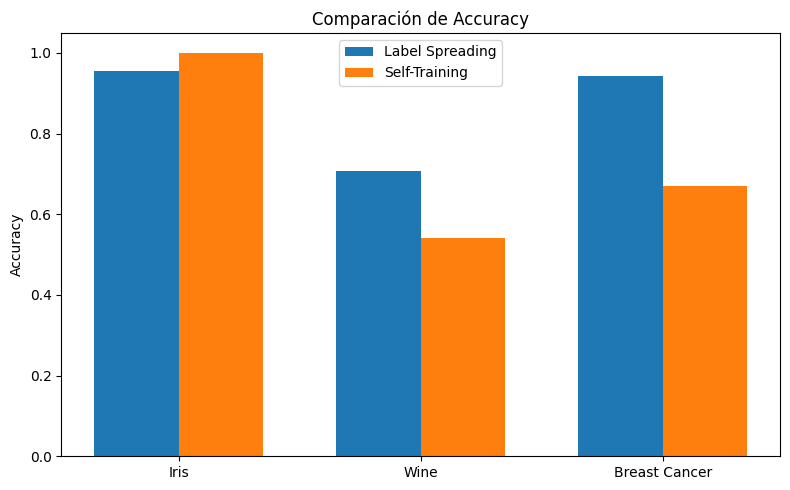

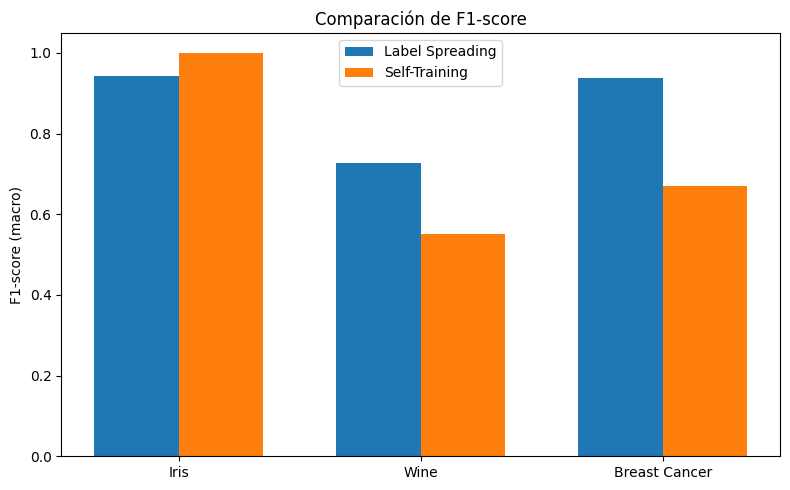

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

#-------------------------------------------------------------------
# Función para cargar datasets reales con un 50% de etiquetas ocultas
#-------------------------------------------------------------------
def load_real_datasets():
    datasets = {}
    rng = np.random.default_rng(42)

    for name, loader in zip(["Iris", "Wine", "Breast Cancer"], [load_iris, load_wine, load_breast_cancer]):
        data = loader()
        X, y = data.data, data.target
        y_masked = y.copy()
        mask = rng.choice(len(y_masked), size=int(0.5 * len(y_masked)), replace=False)  # Reducido al 50%
        y_masked[mask] = -1

        # Verificar si todas las clases tienen al menos una muestra etiquetada
        while len(set(y_masked[y_masked != -1])) < len(set(y)):
            mask = rng.choice(len(y_masked), size=int(0.5 * len(y_masked)), replace=False)
            y_masked = y.copy()
            y_masked[mask] = -1

        datasets[name] = (X, y_masked)

    return datasets

#------------------------------------------------------------
# Función para entrenar y evaluar modelos semi-supervisados
#------------------------------------------------------------
def evaluate_semi_supervised(model, X, y, dataset_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    try:
        model.fit(X_train, y_train)
    except ValueError as e:
        print(f"[ERROR] No se pudo entrenar {dataset_name} con {model.__class__.__name__}: {e}")
        return None, None, None, None

    test_labeled_mask = (y_test != -1)
    X_test_labeled, y_test_labeled = X_test[test_labeled_mask], y_test[test_labeled_mask]
    if len(y_test_labeled) == 0:
        print(f"[ADVERTENCIA] No hay muestras etiquetadas en el test para {dataset_name}. Saltando evaluación.")
        return None, None, None, None

    try:
        y_pred = model.predict(X_test_labeled)
    except Exception as e:
        print(f"[ERROR] No se pudo predecir {dataset_name} con {model.__class__.__name__}: {e}")
        return None, None, None, None

    acc, f1, prec, rec = (
        accuracy_score(y_test_labeled, y_pred),
        f1_score(y_test_labeled, y_pred, average='macro', zero_division=1),
        precision_score(y_test_labeled, y_pred, average='macro', zero_division=1),
        recall_score(y_test_labeled, y_pred, average='macro', zero_division=1)
    )

    print(f"\nResultados en dataset: {dataset_name}")
    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test_labeled, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_test_labeled, y_pred, zero_division=1))

    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test_labeled, y_pred), annot=True, cmap="Blues", fmt="d")
    plt.title(f"Matriz de Confusión - {dataset_name}")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.show()

    return acc, f1, prec, rec

#-------------------------------------------
# MAIN: Evaluación de modelos semi-supervisados
#-------------------------------------------
if __name__ == "__main__":
    real_datasets = load_real_datasets()
    models = {
        'Label Spreading': LabelSpreading(kernel='knn', n_neighbors=5, max_iter=50),  # Se cambió de 'rbf' a 'knn'
        'Self-Training': SelfTrainingClassifier(SVC(probability=True, C=10, gamma=0.01), max_iter=50)
    }
    results = {}

    for dataset_name, (X, y) in real_datasets.items():
        for model_name, model in models.items():
            print(f"\nEvaluando {dataset_name} con {model_name}:")
            results[(dataset_name, model_name)] = evaluate_semi_supervised(model, X, y, dataset_name)

    # Gráficas comparativas
    dataset_names = list(real_datasets.keys())
    accuracies, f1_scores = [], []

    for ds in dataset_names:
        acc_ls, f1_ls, _, _ = results[(ds, 'Label Spreading')]
        acc_st, f1_st, _, _ = results[(ds, 'Self-Training')]
        accuracies.append([acc_ls, acc_st] if acc_ls is not None and acc_st is not None else [0, 0])
        f1_scores.append([f1_ls, f1_st] if f1_ls is not None and f1_st is not None else [0, 0])

    accuracies, f1_scores = np.array(accuracies), np.array(f1_scores)
    x = np.arange(len(dataset_names))
    width = 0.35

    for metric, values, ylabel, title in zip([accuracies, f1_scores], ["Accuracy", "F1-score"], ["Accuracy", "F1-score (macro)"],
                                              ["Comparación de Accuracy", "Comparación de F1-score"]):
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.bar(x - width/2, metric[:, 0], width, label='Label Spreading')
        ax.bar(x + width/2, metric[:, 1], width, label='Self-Training')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(dataset_names)
        ax.legend()
        plt.tight_layout()
        plt.show()

